In [1]:
!pip install langgraph langchain langchain_aws langchain_community mypy_boto3_bedrock_runtime tavily-python langchain_fireworks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB

In [31]:
class OptionSchema(BaseModel):
    """Schema representing a possible answer option for a question in a survey."""
    option: str = Field(description="A potential answer choice for the question in the survey.")

class QuestionSchema(BaseModel):
    """Schema representing a survey question, its type, and its possible answer options."""
    question: str = Field(description="The question text, clearly phrased for survey respondents.")
    question_type: str = Field(description="The type of the question. Choose one: binary, rating, multiple choice, or free text.")
    options: List[OptionSchema] = Field(description="A list of potential answer options. Relevant only for questions with answer choices.")

class QuestionsSchema(BaseModel):
    """Schema for representing a collection of questions along with their types and possible answer options."""
    question_config: List[QuestionSchema] = Field(description="A list of questions, each with its type and potential answer options.")

In [76]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_aws.chat_models import ChatBedrock
from langchain_core.callbacks import StreamingStdOutCallbackHandler
from mypy_boto3_bedrock_runtime.client import BedrockRuntimeClient
from pydantic import BaseModel, Field
from enum import Enum

class ModelKwargs(BaseModel):
    temperature: float = Field(default=0.1, ge=0, le=1)
    max_tokens: int = Field(default=2048, ge=1, le=4096)
    top_p: float = Field(default=0.999, ge=0, le=1)
    top_k: int = Field(default=0, ge=0, le=500)


class ModelId(str, Enum):
    CLAUDE_3_HAIKU = "us.anthropic.claude-3-haiku-20240307-v1:0"
    CLAUDE_3_SONNET = "us.anthropic.claude-3-sonnet-20240229-v1:0"
    CLAUDE_3_OPUS = "us.anthropic.claude-3-opus-20240229-v1:0",
    CLAUDE_3_5_SONNET ="us.anthropic.claude-3-5-sonnet-20240620-v1:0"

class AgentState(TypedDict):
   input: str
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
   researched: list[str]
   output: QuestionsSchema

In [103]:
import boto3

def get_bedrock_client():
    session = boto3.Session(
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        region_name=os.environ["AWS_DEFAULT_REGION"]
    )
    client = session.client("bedrock-runtime")
    return client

In [104]:
def get_langchain_model(
  client: BedrockRuntimeClient,
  model_id: ModelId,
  model_kwargs: ModelKwargs,
  streaming: bool = False,
  verbose: bool = False) -> ChatBedrock:
    return ChatBedrock(
        client=client,
        model_id=model_id.value,
        model_kwargs=model_kwargs.__dict__,
        streaming=streaming,
        verbose=verbose,
        callbacks=[StreamingStdOutCallbackHandler()] if streaming else []
    )

In [105]:
from langchain_fireworks import Fireworks
small_llm=Fireworks(model="accounts/fireworks/models/llama-v3p3-70b-instruct")

In [106]:
client = get_bedrock_client()
llm_generation=get_langchain_model( client= client,model_id=ModelId.CLAUDE_3_SONNET,model_kwargs=ModelKwargs(),)

In [107]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import Annotated
from tavily import TavilyClient
from typing import List

class TavilySearchInput(BaseModel):
    query: Annotated[str, Field(description="The search query string")]
    max_results: Annotated[
        int, Field(description="Maximum number of results to return", ge=1, le=10)
    ] = 5
    search_depth: Annotated[
        str,
        Field(
            description="Search depth: 'basic' or 'advanced'",
            choices=["basic", "advanced"],
        ),
    ] = "basic"

    def process_response(self, response: dict) -> str:
        if not response.get("results"):
            return "No results found."

        results = []
        for item in response["results"]:
            title = item.get("title", "No title")
            content = item.get("content", "No content available")
            url = item.get("url", "No URL available")
            results.append(f"Title: {title}\nContent: {content}\nURL: {url}\n")

        return "\n".join(results)

@tool("tavily_search")
def tavily_search(search_input: TavilySearchInput):
    """ This tool performs a search query using the Tavily API to retrieve information related to the user's query.
    The tool accepts search parameters such as the query string, the maximum number of results to return,
    and the search depth ('basic' or 'advanced').

    The search tool is designed to provide specific, tailored results for survey research,
    offering key insights into various domains like company information, industry trends, and audience analysis.
    The response is processed and formatted for clarity, including the title, content, and URL of each result.

    Args:
    - search_input: A structured input containing the search query string,
      maximum results to return, and the desired search depth.

    Returns:
    - A formatted string with the titles, content, and URLs of the search results, or a message
      indicating no results were found."""
    client = TavilyClient(api_key="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")
    try:
        response = client.search(
            query=search_input.query,
            max_results=search_input.max_results,
            search_depth=search_input.search_depth,
        )
        print(response)
        return search_input.process_response(response)
    except Exception as e:
        return f"An error occurred while performing the search: {str(e)}"


In [87]:
# Create an instance of TavilySearchInput
search_input = TavilySearchInput(
    query="latest trends in AI",
    max_results=5,
    search_depth="advanced"
)

# Convert the search_input to a dictionary

# Invoke the tavily_search function
result = tavily_search.invoke({"search_input":search_input})

# Print the result
print(result)


{'query': 'latest trends in AI', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Five AI Trends To Expect In 2025: Beyond ChatGPT And Friends - Forbes', 'url': 'https://www.forbes.com/sites/nishatalagala/2024/12/30/five-ai-trends-to-expect-in-2025-beyond-chatgpt-and-friends/', 'content': 'Five AI Trends To Expect In 2025: Beyond ChatGPT And Friends Five AI Trends To Expect In 2025: Beyond ChatGPT And Friends AI Trend 1: Agents Everywhere You may have heard the term Agentic AI. AI Trend 2: Transformation Of The Education System AI Trend 3: AI In Science It is also worth noting that while much of the world’s attention and imagination has been focused on Generative AI, billions in funding are pouring into AI use for scientific applications, with new announcements coming in daily for everything from space exploration to medical advances. AI Trend 4: Running Out Of (Easy) Data Couple this with the above trend of AI in Science, and we can imagine efforts to 

In [108]:
class searchQueriesSchema(BaseModel):
    queries: List[str] = Field(description="A list of extracted search queries for the user's query to be used for creating survey questions.")

In [109]:
tools=[tavily_search]

In [110]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.agents import AgentAction

async def researcher(state: TypedDict):
    input = state["input"]
    system_prompt = """
    You are a researcher with access to the **tavily_search** tool, which allows you to search the web for relevant information.
    Your goal is to gather as much context as possible to build relevant and targeted survey questions.
    The user's query contains details about the company, survey's purpose, target audience, industry, and other context.
    You need to extract key elements from this context and design effective search queries.
    """

    human_prompt = """
    Analyze the provided instructions: {input}. Extract the necessary context to generate a structured list of exactly three search queries for gathering relevant information. Each query must align with the following categories. Return only a parsable JSON object with the search queries and no additional text. If no queries can be generated, return an empty JSON object.

    Categories for search queries:

    1. **Company-Specific Insights**:
      - Search for the key products, services, or unique value proposition of the company in the specified industry.
      - Search for recent news, updates, or innovations related to the company.

    2. **Industry Trends and Challenges**:
      - Search for current trends, emerging technologies, or innovations in the industry for [year].
      - Search for common challenges or pain points faced by companies in the given industry.

    3. **Audience Demographics and Preferences**:
      - Search for preferences, expectations, and behaviors of the [target audience] in the [industry].
      - Search for demographic details or specific needs of the target audience related to [product/service].

    4. **Competitive Landscape**:
      - Search for top competitors of [company name] in the [industry] and their key differentiators.
      - Search for strategies or approaches used by [competitor name] to engage with the [target audience].

    5. **Survey Design and Templates**:
      - Search for examples of survey templates or relevant survey questions for the [industry].
      - Search for best practices for designing surveys tailored to the [target audience] and industry.

    6. **Audience-Specific Insights**:
      - Search for behavioral insights or patterns, including preferences, decision-making factors, and feedback on similar products or services.

    7. **Survey Effectiveness**:
      - Search for factors influencing survey effectiveness, including industry-specific challenges and audience engagement strategies.
      - Search for insights into successful surveys or case studies in similar contexts.

    8. **Examples and Use Cases**:
      - Search for real-world examples of surveys conducted in the [industry] or for a similar [target audience].
      - Search for key findings from industry reports, whitepapers, or market research related to surveys.
      {format_instructions}
      """


    messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
    parser = JsonOutputParser(pydantic_object=searchQueriesSchema)
    chat_prompt = ChatPromptTemplate.from_messages(messages)
    chain = chat_prompt | llm_generation | parser

    try:
        response = await chain.ainvoke(input={"input": input,"format_instructions": parser.get_format_instructions()})
        intermediate_steps = []
        for query in response["queries"]:
            tool_name = "tavily_search"
            tool_args = tool_args = TavilySearchInput(
                query=query,
                max_results=3,
                search_depth="basic"
            )
            action = AgentAction(
                tool=tool_name,
                tool_input=tool_args.dict(),
                log="TBD"
            )
            intermediate_steps.append(action)

        return {"intermediate_steps": intermediate_steps}

    except Exception as e:
        print("An unexpected error occurred:", e)
        raise RuntimeError(f"Error fetching the data: {str(e)}")


In [111]:
out = researcher({
    "input": """Generate 10 insightful and customer-centric survey questions for Unibic Cookies.
    The purpose of these questions is to gather actionable feedback for the launch of their new cookie flavors.
    Focus on the following:
    - Identifying customer preferences for flavors, texture, and packaging.
    - Understanding expectations for cookie quality and areas for improvement.
    - Gaining insights into purchasing behavior and decision-making factors.
    - Exploring customer suggestions for enhancing the product experience.

    Frame the questions in a clear and engaging way to maximize response quality and relevance.""",
    "intermediate_steps": [],
})

In [92]:
print(out)

{'intermediate_steps': [AgentAction(tool='tavily_search', tool_input={'query': 'Unibic Cookies products, flavors, and unique selling points', 'max_results': 3, 'search_depth': 'basic'}, log='TBD'), AgentAction(tool='tavily_search', tool_input={'query': 'trends and innovations in the cookie and snack industry 2023', 'max_results': 3, 'search_depth': 'basic'}, log='TBD'), AgentAction(tool='tavily_search', tool_input={'query': 'preferences and behaviors of cookie consumers in India', 'max_results': 3, 'search_depth': 'basic'}, log='TBD')]}


In [112]:
from re import T
tool_str_to_func = {
   "tavily_search": tavily_search,
}

def run_tool(state: TypedDict):
  try:
    tools = state["intermediate_steps"]
    tool_name = state["intermediate_steps"]
    tool_args = state["intermediate_steps"][-1].tool_input
    researched = []
    for tool in tools:
      tool_name = tool.tool
      tool_args = tool.tool_input
      out = tool_str_to_func[tool_name].invoke({"search_input":tool_args})
      researched.append(out)
    return {"researched": researched}
  except Exception as e:
    print("An unexpected error occurred:", e)
    raise RuntimeError(f"Error fetching the data: {str(e)}")

In [113]:
async def question_generator(state: TypedDict):
    input_text = state["input"]
    context = state["researched"]

    system_prompt = (
        "You are an expert assistant specializing in generating survey questions based "
        "on the provided input. Your task is to generate questions, determine their types, "
        "and identify possible answer options based on the provided text."
    )

    human_prompt = """
    Please analyze the provided information and perform the following tasks:
    1. Generate the specified number of survey questions relevant to the company and its industry, considering the target audience.
    2. Determine the question type from these options: binary, multiple-choice, rating, or free-text.
    3. For binary, multiple-choice, or rating questions, list the possible answer options.
    4. Each question should include its type and possible options (if applicable).
    5. Present the results in a **parsable JSON format** without any additional text—only clean JSON output.
    6. If no valid questions are found or if the input text is empty, return an empty JSON object.

    Here is the input to base the questions on:
    '''{prompt}'''

    Here is the context about the company and all relevant details:
    '''{context}'''

    {format_instructions}
    """
    print(context)
    parser = JsonOutputParser(pydantic_object=QuestionsSchema)

    messages = [
        ("system", system_prompt),
        ("human", human_prompt),
    ]

    chat_prompt = ChatPromptTemplate.from_messages(messages)
    chain = chat_prompt | llm_generation | parser

    try:
        response = await chain.ainvoke({"prompt": input_text,"context": context,"format_instructions": parser.get_format_instructions()})
        return {"output": response}
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise RuntimeError(f"Error fetching the data: {str(e)}")


In [114]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("researcher", researcher)
graph.add_node("tavily_search", run_tool)
graph.add_node("question_generator", question_generator)
graph.add_edge("tavily_search", "question_generator")

graph.set_entry_point("researcher")


for tool_obj in tools:
    graph.add_edge("researcher", tool_obj.name)


graph.add_edge("question_generator", END)


runnable = graph.compile()



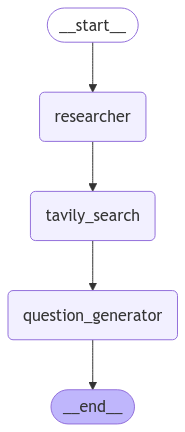

In [115]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [116]:
out = await runnable.ainvoke({
    "input": "I want 10 customer-centric questions for unibic for the launch of thier new flavours in cookies",
    "intermediate_steps": [],
    "researched": [],
    "output": {},
})

<ipython-input-110-4f2fa6829c27>:73: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  tool_input=tool_args.dict(),


{'query': 'unibic cookies new flavors launch', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Unibic Biscott Review - Mishry (2024)', 'url': 'https://www.mishry.com/unibic-caramel-and-cinnamon-biscuits-review', 'content': "Nah! It's Biscott! Our Review of Unibic's New Cinnamon Biscuits. ... We would have liked them a lot more if the flavor of cinnamon was bolder. Written By Saachi Gera Review led by: Nishtha Asrani Sethi, Tanu Ganguly. Updated: August 20, 2024 4 Mins Read. ... Unibic's new launch is a cinnamon and caramel flavored biscuit, Biscott.", 'score': 0.8585411, 'raw_content': None}, {'title': "Unibic Cookies: WHAT'S NEW? - Amazon.in", 'url': 'https://www.amazon.in/stores/UnibicCookies/WhatsNew/page/A7C1FC47-A6DE-4048-AF86-64D53544C88F', 'content': 'Unibic New Product Launches. ... Unibic Cookies,Assorted Cookies,75 G (Pack Of 12)|Biscuits Combo Pack|Choco Chip Cookies|Butter Cookies|Fruit & Nut Cookies||Honey Oatmeal I Cashew Cookies I Jeera 

Exception ignored in: <coroutine object researcher at 0x7cfa6c059bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py", line 27, in run
KeyError: '__builtins__'
Exception ignored in: <coroutine object researcher at 0x7cfa6c059bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py", line 27, in run
KeyError: '__builtins__'


In [117]:
print(out["output"])

{'question_config': [{'question': "How likely are you to try Unibic's new cookie flavors?", 'question_type': 'rating', 'options': [{'option': 'Very likely'}, {'option': 'Somewhat likely'}, {'option': 'Neutral'}, {'option': 'Somewhat unlikely'}, {'option': 'Very unlikely'}]}, {'question': 'Which of the following factors influence your decision to purchase cookies? (Select all that apply)', 'question_type': 'multiple choice', 'options': [{'option': 'Taste'}, {'option': 'Brand reputation'}, {'option': 'Nutritional value'}, {'option': 'Packaging'}, {'option': 'Price'}, {'option': 'Sustainability'}]}, {'question': 'How important is the flavor intensity of cookies to you?', 'question_type': 'rating', 'options': [{'option': 'Extremely important'}, {'option': 'Very important'}, {'option': 'Moderately important'}, {'option': 'Slightly important'}, {'option': 'Not at all important'}]}, {'question': 'What is your preferred cookie texture?', 'question_type': 'multiple choice', 'options': [{'option